In [135]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [136]:
# setting default fontsizes for plots

s=20 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [137]:
#suff= ''
suff = '_corrected'

In [138]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # subs *movies

(1049, 10)

In [139]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vidnames

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [140]:
from mne.stats import fdr_correction
from multipy.fdr import lsu
#from multipy.data import neuhaus

# ALL MOVIES    

In [142]:
sub_id_all = np.load(os.path.join(data_file_loc,f'sub_id_all{suff}.npy'))
sub_id_all.shape# sub_id_all[143]

(1049,)

In [143]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm
import time

In [144]:
responses.shape, suff

((1049, 10), '_corrected')

In [145]:
# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((responses.shape[0],268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}{suff}.npy')
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

from datetime import datetime


In [147]:
movie_rfx = 1 # 1: include subject and movie as rfx, 0: have only subject as
if movie_rfx == 1:
    lme_suff = '_movieRFX'
else: 
    lme_suff = ''

In [148]:
load_all = 1 # 1: load saved coefs, 0: run the LME

In [149]:
# Yes v Unsure (ALL)

if load_all == 0: 
    coef_soc_uns_ALL, coef_uns_nonsoc_ALL= [np.empty((268,)) for _ in range(2)]
    coef_soc_uns_ALL[:], coef_uns_nonsoc_ALL[:] = [np.nan]*2
    pval_soc_uns_ALL, pval_uns_nonsoc_ALL = [np.empty((268,)) for _ in range(2)]
    pval_soc_uns_ALL[:], pval_uns_nonsoc_ALL[:] = [np.nan]*2

flname = f'lmecoefs_all_soc_v_unsure_ALLmovies{lme_suff}.npy'

if load_all == 1:    
    [coef_soc_uns_ALL,pval_soc_uns_ALL] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',flname), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in range(10):
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 0] # yes v unsure
        df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
        if movie_rfx == 0:
            model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        else:
            model = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID, movie
    
        model.fit(factors={"response":["Unsure","Social"]},summary = False, verbose = False)
        if n == 0:
            print('model:',model.fit(factors={"response":["Unsure","Social"]}))
        coef_soc_uns_ALL[n] = model.coefs['Estimate'][1]
        pval_soc_uns_ALL[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',flname), [coef_soc_uns_ALL,pval_soc_uns_ALL])
    print('Done on/at:',datetime.now()) # cell run at)

In [150]:
# Unsure vs. Non-social
flname = f'lmecoefs_all_unsure_v_nonsoc_ALLmovies{lme_suff}.npy'

if load_all == 1:
    [coef_uns_nonsoc_ALL,pval_uns_nonsoc_ALL] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',\
        flname), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in range(10): # MAKE SURE ALL 10 MOVIES ARE HERE
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 1] # no v unsure
            
        df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
        if movie_rfx == 0:
            model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        else:
            model = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID, movie
    
        model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False)
        if n == 0:
            print(model.fit(factors={"response":["Non-social","Unsure"]}))
        #print('model 2:',model.fit())
        coef_uns_nonsoc_ALL[n] = model.coefs['Estimate'][1]
        pval_uns_nonsoc_ALL[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',flname),[coef_uns_nonsoc_ALL,pval_uns_nonsoc_ALL])
    print('Done on/at:',datetime.now()) # cell run at)

In [151]:
# for comparison with the other main figure if needed
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
#nodes_randuns_all = nodes_coaxbill_rand_all & nodes_rand_SNS_SUNS
#len(np.where(nodes_randuns_all)[0])

len(np.where(nodes_coaxbill_rand_all)[0])

70

In [152]:
# FDR-correct s>unsure and unsure >ns
pval_soc_uns_corr_ALL = lsu(pval_soc_uns_ALL,q=.05)
pval_uns_nonsoc_corr_ALL = lsu(pval_uns_nonsoc_ALL,q=.05)
pval_soc_uns_unc_ALL  = pval_soc_uns_ALL <.05
pval_uns_nonsoc_unc_ALL  = pval_uns_nonsoc_ALL <.05

In [153]:
# ALL social>unsure and unsure>non-social or vice-versa
# uncorrected
nodes_all_SUNS_UNSNS_unc_ALL = (pval_soc_uns_unc_ALL) & (pval_uns_nonsoc_unc_ALL) & \
(np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL)) & nodes_coaxbill_rand_all 

#corrected
nodes_all_SUNS_UNSNS_ALL = (pval_soc_uns_corr_ALL) & (pval_uns_nonsoc_corr_ALL) & \
    (np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL))  & nodes_coaxbill_rand_all

print('all:', len(np.where(nodes_all_SUNS_UNSNS_unc_ALL)[0]), len(np.where(nodes_all_SUNS_UNSNS_ALL)[0]))


all: 21 5


# Plot

In [154]:
## Save ROIs

fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')

#import plotting functions

cols = ['k','k','g']
lw = [3,2,1]

lbl = [str.upper(x[0:4]) for x in vidnames]
lbl

from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
import nibabel as nib
from nilearn import datasets
bg_img = datasets.load_mni152_template()


from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [155]:
movie_rfx

1

In [156]:
#import brain_plot_functions
#from importlib import reload
#reload(brain_plot_functions)
    
def surf_plot_all(fig, ax, nodes, params, movie_rfx, plot_v5=True):

    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']

    #LH
    ax_surf = ax[0,0] # left lateral (upper left)
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    if movie_rfx:
        texture_contour = vol_to_surf(color_rois(nodes_all_SUNS_UNSNS_ALL), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])

    ax_surf = ax[1,0] # left medial (lower left)
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    if movie_rfx:
        plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])
    
    #RH
    ax_surf = ax[0,1] # upper right
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    if movie_rfx:
        texture_contour = vol_to_surf(color_rois(nodes_all_SUNS_UNSNS_ALL), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])
    
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.3, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    
    ax_surf = ax[1,1] # lower right
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    
    if movie_rfx:
        plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    
    if plot_v5:
        v5_texture = vol_to_surf(v5_roi_nii, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
        thr99 = np.quantile(v5_texture,.99)
        v5_texture[v5_texture<thr99] = 0
        v5_texture[v5_texture!=0] = 1
        plot_surf_contours(fsaverage.infl_left,  v5_texture, figure=surf_plot1, legend=False, axes=ax[0,0],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])
        
        v5_texture = vol_to_surf(v5_roi_nii, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
        thr99 = np.quantile(v5_texture,.99)
        v5_texture[v5_texture<thr99] = 0
        v5_texture[v5_texture!=0] = 1
        plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot3, legend=False, axes=ax[0,1],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])


    ax[0,0].dist = 7 # change viewing distance to "zoom in" to surface plots
    ax[0,1].dist = 7
    ax[1,0].dist = 7
    ax[1,1].dist = 7

    #fig.colorbar(surf_plot3.axes[2])
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)
    #fig.colorbar(surf_plot2, shrink=2, aspect=10)
#box = surf_plot3.axes[4].get_position()
#surf_plot3.axes[4].set_position([box.x0, box.y0, box.width, box.height])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

In [157]:
print('all:', len(np.where(nodes_all_SUNS_UNSNS_unc_ALL)[0]), len(np.where(nodes_all_SUNS_UNSNS_ALL)[0]))

all: 21 5


In [158]:
v5_roi = 'v5_association-test_z_FDR_0.01.nii'
v5_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{v5_roi}'
v5_roi_nii = nib.load(v5_roi_loc)

In [159]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')
#coords = [np.round(eval(shen268_lbl[str(n+1)][0])['coords'][2]) for n in np.where(common_nodes_soc_uns_nonsoc)[0]]
#coords
comp_lbls = ['Soc_Unsure','Unsure_Nonsoc']

In [160]:
movie_rfx

1

In [161]:
if movie_rfx:
    print('sub and movie rfx')
    print(min(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_unc_ALL]), max(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_unc_ALL] ))
else:
    print('sub only rfx')
    print(min(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL]), max(coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL]) )

sub and movie rfx
0.08295005946452656 0.23133698591904572


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


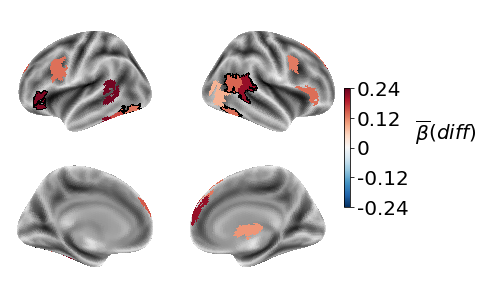

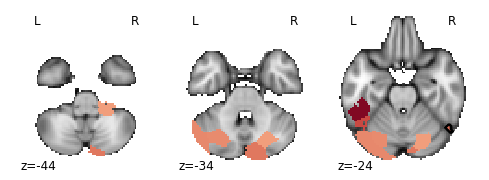

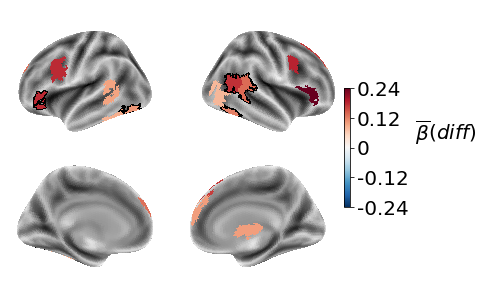

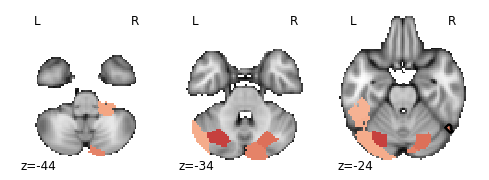

In [162]:
# surface plots
if movie_rfx:
    vmin,vmax = -.24,.24
else:
    vmin,vmax = -.55,.55
    
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL'

for comp in range(2):
    nodes = np.zeros((268,))
    if comp == 0:    
        txt = '  'r"$\overline{\beta}{(diff)}$"
        if movie_rfx:
            nodes[nodes_all_SUNS_UNSNS_unc_ALL] = coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_unc_ALL] 
        else:
            nodes[nodes_all_SUNS_UNSNS_ALL] = coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL] 
        
    else:
        txt = '  'r"$\overline{\beta}{(diff)}$"
        if movie_rfx:
            nodes[nodes_all_SUNS_UNSNS_unc_ALL] = coef_uns_nonsoc_ALL[nodes_all_SUNS_UNSNS_unc_ALL]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)
        else:
            nodes[nodes_all_SUNS_UNSNS_ALL] = coef_uns_nonsoc_ALL[nodes_all_SUNS_UNSNS_ALL]
    
    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
    plot_V5 = False # change here to remove V5 contours
    surf_plot_all(fig,ax,nodes, params, movie_rfx, plot_V5)
    v5_flname_suff = 'withV5' if plot_V5==True else ''
    plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/surf_all4_{comp_lbls[comp]}_{v5_flname_suff}{lme_suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
        
    img = roi_to_brain(pd.Series(nodes), mask_x)
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    if movie_rfx:
        ax_plot.add_contours(color_rois(nodes_all_SUNS_UNSNS_ALL),linewidths=1, colors=['k'],linestyles ='-',filled=False)

    plt.savefig(os.path.join(fig_save_loc,f'ALL_MOVIES/{comp_lbls[comp]}_axial{lme_suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

# random mech

In [42]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_Random mechanical{suff}.npy'))

soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"

print(f'movie={vidnames[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])},unsure={len(np.where(unsure_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_rand_S_NS = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_NS = lsu(pval_slope_rand_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_NS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_rand_S_UNS_unc = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_UNS = lsu(pval_slope_rand_S_UNS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_UNS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_rand_UNS_NS_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_UNS_NS = lsu(pval_slope_rand_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_UNS_NS = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

_,pval_slope_rand_S_UNS_unc1 = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
_,pval_slope_rand_UNS_NS_unc1 = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)

pval_slope_rand_UNS_NS_unc = pval_slope_rand_UNS_NS_unc<.05
pval_slope_rand_S_UNS_unc = pval_slope_rand_S_UNS_unc < .05

# social>unsure and unsure>non-social or vice-versa, both corrected
nodes_rand_SUNS_UNSNS = (pval_slope_rand_S_UNS) & (pval_slope_rand_UNS_NS) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS:',len(np.where(nodes_rand_SUNS_UNSNS)[0])) # no sig  ndoes for RAND

#### same as above, unc.
# social>unsure and unsure>non-social or vice-versa, both uncorrected
nodes_rand_SUNS_UNSNS_unc = (pval_slope_rand_S_UNS_unc) & (pval_slope_rand_UNS_NS_unc) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS_unc:',len(np.where(nodes_rand_SUNS_UNSNS_unc)[0])) # 5 sig nodes for RAND


movie=Random mechanical,soc=107,nonsocial=670,unsure=225
nodes_rand_SUNS_UNSNS: 0
nodes_rand_SUNS_UNSNS_unc: 5


In [43]:
common_nodes_soc_uns_nonsoc =  nodes_rand_SUNS_UNSNS_unc & nodes_all_SUNS_UNSNS_ALL
np.where(common_nodes_soc_uns_nonsoc) # no intersection regions (also not the best idea since all movies includes rand)

(array([], dtype=int64),)

- Let's try to sort the "ALL movies" n nodes by how close the beta_S_uns/bdeta_uns_NS ratio is to 1.

In [44]:
responses.shape, movie_ind

((1049, 10), 4)

In [53]:
# get a variable storing whether nodes show a difference in the end

soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"
pval_end_rand,    meandiff_end_rand, ntimepts_rand    = [np.empty((268,2)) for _ in range(3)]
pval_end_rand[:], meandiff_end_rand[:], ntimepts_rand[:] = [np.nan]*3
 
end_trs = 5
for n in range(268):# np.arange(10):
    tcn1 = np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[unsure_inds,n,-end_trs:,4],axis=1)
    ntimepts_rand[n,0] =  np.sum(np.sign(np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,0] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,0] = np.nanmean(tcn1) - np.nanmean(tcn2)
    
    tcn1 = np.nanmean(tcs_run_z[unsure_inds, n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[nonsoc_inds, n,-end_trs:,4],axis=1)
    ntimepts_rand[n,1] =  np.sum(np.sign(np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[nonsoc_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,1] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,1] = np.nanmean(tcn1) - np.nanmean(tcn2)

end_diff_rand_s_uns_ns = (np.sign(meandiff_end_rand[:,0]) == np.sign(meandiff_end_rand[:,1])) & \
     (pval_end_rand[:,0] < .05) & (pval_end_rand[:,1] < .05)

meandiff_end_rand.shape ## 268, [s-uns,uns-ns]

(268, 2)

In [54]:
mean_diff_diff_rand  = []
mean_diff_ratio_rand = []
mean_diff_ratio_rand_end = []
for n in range(268):
    d = meanDiff_sl_rand_S_UNS[n] - meanDiff_sl_rand_UNS_NS[n]
    r = meanDiff_sl_rand_S_UNS[n]/ meanDiff_sl_rand_UNS_NS[n]
    r_end = meandiff_end_rand[n,0]/meandiff_end_rand[n,1]
    '''if d < 0:
        d = np.nan
    if r <0:
        r = np.nan'''
    mean_diff_diff_rand.append(d)
    mean_diff_ratio_rand.append(r)
    mean_diff_ratio_rand_end.append(r_end)
mean_diff_diff_rand = np.array(mean_diff_diff_rand)
mean_diff_ratio_rand = np.array(mean_diff_ratio_rand)
mean_diff_ratio_rand_end = np.array(mean_diff_ratio_rand_end)
seq = np.argsort(mean_diff_ratio_rand)
mean_diff_ratio_rand[seq[::-1]][:10]

array([452.94856714,  93.78015065,  47.34807706,  38.85799133,
        34.21487963,  29.63822949,  24.89432263,  23.23899355,
        21.11047522,  18.97826114])

In [55]:
closeness_to_1 = []
for i in mean_diff_ratio_rand:
    if i > 1:
        closeness_to_1.append(1/i)
    else:
        closeness_to_1.append(i)


closeness_to_1_end = []
for i in mean_diff_ratio_rand_end:
    if i > 1:
        closeness_to_1_end.append(1/i)
    else:
        closeness_to_1_end.append(i)

mean_closeness_to_1 = [np.nanmean([closeness_to_1[i],closeness_to_1_end[i]]) for i in range(268)]

In [56]:
df = pd.DataFrame({'ratio':mean_diff_ratio_rand, 'closeness_to_1':closeness_to_1, 'glm_nodes':nodes_coaxbill_rand_all, 'fdr_all': nodes_all_SUNS_UNSNS_ALL, 
'unc_sig': nodes_all_SUNS_UNSNS_unc_ALL,
'ROI_label':[eval(shen268_lbl[str(n+1)][0])['name'] for n in range(268)], 'mean_diff_end5': mean_diff_ratio_rand_end, 'closeness_to_1_end':closeness_to_1_end,
'mean_closeness_to_1':mean_closeness_to_1})
df =  df.reset_index()
df = df.loc[df['glm_nodes'] & (df['fdr_all']) & (df['ratio']>0) & (df['mean_diff_end5']>0),:]  # glm nodes from analysis 2, fdr_corr sig for all movies and non-negative beta ratio for rand
print(df.shape)
df.sort_values(by=['mean_closeness_to_1'],ascending=False, inplace=True)
df.iloc[:10,:]

(5, 10)


,index,ratio,closeness_to_1,glm_nodes,fdr_all,unc_sig,ROI_label,mean_diff_end5,closeness_to_1_end,mean_closeness_to_1
150,150,1.263983,0.791150,True,True,True,51.03% Frontal_Orbital_Cortex; 25.77% Inferior...,1.882368,0.531246,0.661198
65,65,2.294012,0.435918,True,True,True,35.14% Inferior_Temporal_Gyrus_temporooccipita...,1.774467,0.563550,0.499734
49,49,1.223952,0.817026,True,True,True,35.64% Angular_Gyrus; 25.13% Middle_Temporal_G...,11.466512,0.087210,0.452118
64,64,1.703613,0.586988,True,True,True,51.09% Middle_Temporal_Gyrus_temporooccipital_...,11.624344,0.086026,0.336507
205,205,4.552133,0.219677,True,True,True,55.19% Lateral_Occipital_Cortex_inferior_divis...,32.140055,0.031114,0.125396


In [57]:
nodes_ind = df.iloc[:,0].values
nodes_ind

array([150,  65,  49,  64, 205])

In [58]:
df['ROI_label'].values[:10]

array(['51.03% Frontal_Orbital_Cortex; 25.77% Inferior_Frontal_Gyrus_pars_triangularis; 11.73% Frontal_Pole; 8.38% Frontal_Operculum_Cortex',
       '35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fusiform_Cortex; 7.66% Occipital_Fusiform_Gyrus',
       '35.64% Angular_Gyrus; 25.13% Middle_Temporal_Gyrus_temporooccipital_part; 22.21% Lateral_Occipital_Cortex_inferior_division; 16.62% Lateral_Occipital_Cortex_superior_division',
       '51.09% Middle_Temporal_Gyrus_temporooccipital_part; 26.64% Supramarginal_Gyrus_posterior_division; 12.90% Angular_Gyrus; 6.04% Superior_Temporal_Gyrus_posterior_division',
       '55.19% Lateral_Occipital_Cortex_inferior_division; 29.41% Occipital_Fusiform_Gyrus; 8.65% Temporal_Occipital_Fusiform_Cortex; 6.75% Inferior_Temporal_Gyrus_temporooccipital_part'],
      dtype=object)

# plot timecourses

In [59]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
print(vid_start_rel_tr)
l_task = 28

[6 13 13 13 13 6 13 13 13 13]


In [60]:
def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):
    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan
    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1

#select subs who responded "social" to the yes movie and nonsocial to the no movie
print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_run_z.shape)
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_run_z.shape)

# collapse across all movies except random  mech and runs (for timecourse plots)
tcs_run_resh_yes_allexceptR = []
tcs_run_resh_no_allexceptR  = []
tcs_run_resh_unsure_allexceptR  = []
subs_resh_yes_allexceptR  = []
subs_resh_no_allexceptR  = []
subs_resh_unsure_allexceptR  = []
for m in [0,1,2,3,5,6,7,8,9]:
    tcs_run_resh_yes_allexceptR.append(tcs_run_z[responses[:,m]==1,:,:,m])# subsm * 268 * 31
    tcs_run_resh_no_allexceptR.append(tcs_run_z[responses[:,m]==0,:,:,m])# subsm * 268 * 31
    tcs_run_resh_unsure_allexceptR.append(tcs_run_z[responses[:,m]==9,:,:,m])# subsm * 268 * 31
    subs_resh_yes_allexceptR  += list(np.where(responses[:,m]==1)[0])# subsm * 268 * 31, keep track of subject seq
    subs_resh_no_allexceptR   += list(np.where(responses[:,m]==0)[0])# subsm * 268 * 31
    subs_resh_unsure_allexceptR  += list(np.where(responses[:,m]==9)[0])# subsm * 268 * 31
tcs_run_resh_yes_allexceptR  = np.concatenate(tcs_run_resh_yes_allexceptR ,axis=0)
tcs_run_resh_no_allexceptR   = np.concatenate(tcs_run_resh_no_allexceptR ,axis=0)
tcs_run_resh_unsure_allexceptR  = np.concatenate(tcs_run_resh_unsure_allexceptR ,axis=0)
print('Across all movies except random mech: \nyes:'+ str(tcs_run_resh_yes_allexceptR .shape) + ',\nno:' + str(tcs_run_resh_no_allexceptR .shape) + ',\nunsure:' + str(tcs_run_resh_unsure_allexceptR .shape))


run-wise norm data.
before: (1049, 268, 56, 10)
after: (1049, 268, 31, 10)
Across all movies except random mech: 
yes:(4849, 268, 31),
no:(3741, 268, 31),
unsure:(446, 268, 31)


In [61]:
# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()
TR=.72


In [62]:
nodes_ind10 = nodes_ind[:10]
[[n,eval(shen268_lbl[str(n+1)][0])['name']] for n in nodes_ind10]

[[150,
  '51.03% Frontal_Orbital_Cortex; 25.77% Inferior_Frontal_Gyrus_pars_triangularis; 11.73% Frontal_Pole; 8.38% Frontal_Operculum_Cortex'],
 [65,
  '35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fusiform_Cortex; 7.66% Occipital_Fusiform_Gyrus'],
 [49,
  '35.64% Angular_Gyrus; 25.13% Middle_Temporal_Gyrus_temporooccipital_part; 22.21% Lateral_Occipital_Cortex_inferior_division; 16.62% Lateral_Occipital_Cortex_superior_division'],
 [64,
  '51.09% Middle_Temporal_Gyrus_temporooccipital_part; 26.64% Supramarginal_Gyrus_posterior_division; 12.90% Angular_Gyrus; 6.04% Superior_Temporal_Gyrus_posterior_division'],
 [205,
  '55.19% Lateral_Occipital_Cortex_inferior_division; 29.41% Occipital_Fusiform_Gyrus; 8.65% Temporal_Occipital_Fusiform_Cortex; 6.75% Inferior_Temporal_Gyrus_temporooccipital_part']]

array([ 49,  64,  65, 150, 205])

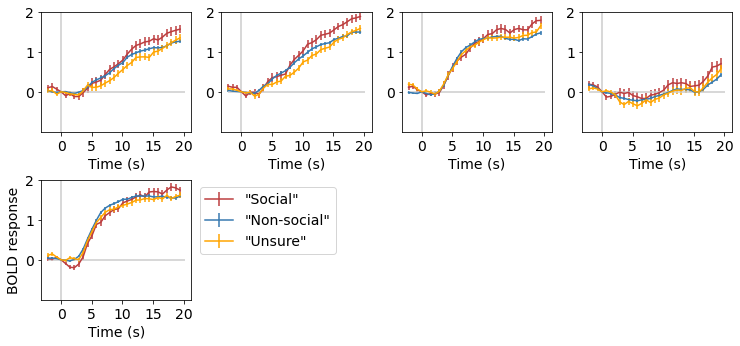

In [71]:
# plot timecourses of common nodes

if movie_rfx==1:
     nodes_to_plot = np.where(nodes_all_SUNS_UNSNS_ALL)[0]
else:
     nodes_to_plot = nodes_ind10

[ymin,ymax] = [-1,2]
xlbls = [0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]
ncols = 4
nrows = int(np.ceil(nodes_to_plot.shape[0]/ncols))
#line_loc = []
#fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=False, 
#sharey=False, figsize = (12,4)) # figsize = (20,15))
if movie_rfx == 1:
     fig,ax =plt.subplots(nrows = nrows, ncols = ncols, sharex=False, 
     sharey=False, figsize = (12,4)) # figsize = (20,15))
else:
     fig,ax =plt.subplots(nrows = nrows, ncols = ncols, sharex=False, 
     sharey=False, figsize = (12,6)) # figsize = (20,15))

#plt.suptitle('Left hemisphere', fontweight='bold')  

for i,n in enumerate(nodes_to_plot): #for i,n in enumerate(df['Nodes']):
     #fig, ax = plt.figure(i+1,figsize=(10,5))   
     
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
     movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
     movieTC_unsure  = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
     
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=1.5,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=1.5,label ='"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=1.5,label ='"Unsure"')
     ax1.vlines(tr0_ind,-1,2,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     #ax1.set_title(f'Node {n+1}',fontweight = 'bold')
     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls, fontsize=14)
     ax1.set_yticks([0,1,2])
     ax1.set_yticklabels([i for i in [0,1,2]],fontsize=14)
     
     #ax[r,0].set_ylabel('BOLD\n(a.u.)')
     #txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
     #ax1.text(35,0,txt)
     if  (c==0) & (r == int(nrows/2)):
          ax1.set_ylabel('BOLD response', fontsize=14 )
     #if r == nrows-1:
     ax1.set_xlabel('Time (s)', fontsize=14 )
     if i==len(nodes_to_plot)-1:#(r==0) and (c==ncols-1):
          ax1.legend(bbox_to_anchor = [2.01,1],fontsize=14)

     MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
     #ax1.annotate(f'z={int(np.round(MNIz))}',xy=(0,.7), xycoords='axes fraction',size = 12)
    
if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(nodes_to_plot)[0]))):
          ax[r,c+1+i].axis('off')
#plt.tight_layout()
plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.2, 
                        hspace=.4)


plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs_tc{lme_suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

In [64]:
responses

array([[nan,  0.,  0., ...,  0.,  1.,  9.],
       [ 1.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  9.,  0., ...,  0.,  1.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  1.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  0.]])

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 1.0
8 1.0
9 1.0


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


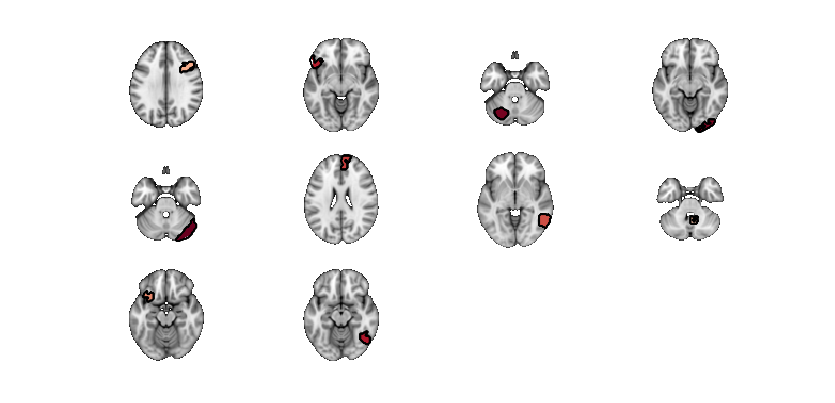

In [337]:
# save axial plots of each roi
# TAKES TIME, RUN ONLY IF NECESSARY!

start_time = time.time()
fig,axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12,6))
for i,n in enumerate(nodes_ind10): #for i,n in enumerate(df['Nodes']):
    print(i, np.round((time.time()-start_time)/60))
    #ax = fig.add_subplot(nrows,1,i+1)
    r = int(np.floor(i/ncols))
    c = int(i%ncols)
    ax = axs[r,c]
    
    nodes = np.zeros((268,))
    nodes[n] = meanDiff_sl_rand_S_UNS[n]

    img = roi_to_brain(pd.Series(nodes), mask_x)
    '''zsl = row[1]['MNIz']
    if np.abs(zsl-zslices[0]) < np.abs(zsl-zslices[1]):
        zsl = zslices[0]
    else:
        zsl = zslices[1]'''
    MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',cut_coords =[MNIz],cmap = 'RdBu_r',bg_img = bg_img,colorbar= False, threshold = .001,\
    vmin = -.26,vmax=.26,axes =ax,figure=fig,annotate=False) # cmap = 'plasma'
    ax_plot.add_contours(color_rois((nodes)),linewidths=1, colors=['k'],linestyles='solid')
    #ymin,ymax = plt.ylim()
    #plt.ylim(ymin,10)
    #xmin,xmax = plt.xlim()
    #plt.xlim(xmin,10)

if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(nodes_ind10)[0]))):
          axs[r,c+1+i].axis('off')
plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs{suff}.png'),dpi=300,bbox_inches='tight',facecolor='none', edgecolor='none')
#plt.clf()

# Social v unsure v nonsocial

## Random Mech

In [56]:
nodes = np.zeros((268,))
if comp == 0:
    #txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
    txt = '  'r"$\overline{\beta}{(diff)}$"
    
    nodes[rand_nodes_nosig] = meanDiff_sl_rand_S_UNS[rand_nodes_nosig]
else:
    #txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
    txt = '  'r"$\overline{\beta}{(diff)}$"
    nodes[rand_nodes_nosig] = meanDiff_sl_rand_UNS_NS[rand_nodes_nosig]

fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}

surf_plot1(fig,ax,nodes,params)


NameError: name 'rand_nodes_nosig' is not defined

- overall, 5 nodes show  S>unsure>NS at the uncorrected threshold for random mech


- no intersecting node, and follow-up checks showed that this is because of loss of significance in the random mech nodes
- let's use threshodlded differences in slope and differences at the end

In [254]:
rand_nodes_nosig = (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) & \
    (ntimepts_rand[:,0] == end_trs) & (ntimepts_rand[:,1] == end_trs) & \
    (np.sign(meandiff_end_rand[:,0]) == np.sign(meandiff_end_rand[:,1]))  & \
    (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meandiff_end_rand[:,0])) 
np.where(rand_nodes_nosig)[0].shape

(38,)

In [255]:
#((meandiff_end_rand[:,0]/meandiff_end_rand[:,1]) < 5 ) &
#((meandiff_end_rand[:,0]/meandiff_end_rand[:,1]) > 0.2) & 
   

In [256]:
# get a variable storing whether nodes show a difference in the end
#if load ==0:

pval_end_allexcept,    meandiff_end_allexcept, ntimepts_allexcept = [np.empty((268,2)) for _ in range(3)]
pval_end_allexcept[:], meandiff_end_allexcept[:], ntimepts_allexcept[:] = [np.nan]*3

for n in range(268):# np.arange(10):
    
    tcn1 = np.nanmean(tcs_run_resh_yes_allexceptR[:,   n,-end_trs:],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_resh_unsure_allexceptR[:,n,-end_trs:],axis=1)
    
    _,pval_end_allexcept[n,0] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_allexcept[n,0] = np.nanmean(tcn1) - np.nanmean(tcn2)
    ntimepts_allexcept[n,0] =  np.sum(np.sign(np.nanmean(tcs_run_resh_yes_allexceptR[:,   n,-end_trs:],axis=0) - \
         np.nanmean(tcs_run_resh_unsure_allexceptR[:,   n,-end_trs:],axis=0)))
    
    tcn1 = np.nanmean(tcs_run_resh_unsure_allexceptR[:, n,-end_trs:],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_resh_no_allexceptR[:,     n,-end_trs:],axis=1)
    ntimepts_allexcept[n,1] =  np.sum(np.sign(np.nanmean(tcs_run_resh_unsure_allexceptR[:,   n,-end_trs:],axis=0) - \
         np.nanmean(tcs_run_resh_no_allexceptR[:,   n,-end_trs:],axis=0)))
    
    _,pval_end_allexcept[n,1] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_allexcept[n,1] = np.nanmean(tcn1) - np.nanmean(tcn2)

In [279]:
all_except_nosig = (np.sign(coef_soc_uns) == np.sign(coef_uns_nonsoc)) &\
    (np.sign(meandiff_end_allexcept[:,0]) == np.sign(meandiff_end_allexcept[:,1]))  & \
    (np.sign(coef_soc_uns) == np.sign(meandiff_end_allexcept[:,0])) & \
    (ntimepts_allexcept[:,0] == end_trs) & (ntimepts_allexcept[:,1] == end_trs)
    
np.where(all_except_nosig)[0].shape

(36,)

In [ ]:
# all and rand, fdr-corrected: nodes_all_SUNS_UNSNS, rand
'''common_nodes_soc_uns_nonsoc_nosig =  nodes_all_SUNS_UNSNS & rand_nodes_nosig \
    & all_except_nosig & \
    (np.sign(coef_soc_uns) == np.sign(meanDiff_sl_rand_S_UNS)) & \
    (nodes_coaxbill_rand_all)
np.where(common_nodes_soc_uns_nonsoc_nosig)[0],np.where(common_nodes_soc_uns_nonsoc_nosig)[0].shape'''

In [281]:
# all except and rand, fdr-corrected: nodes_all_SUNS_UNSNS, rand
common_nodes_soc_uns_nonsoc_nosig =  nodes_all_SUNS_UNSNS & rand_nodes_nosig \
    & all_except_nosig & \
    (np.sign(coef_soc_uns) == np.sign(meanDiff_sl_rand_S_UNS)) & \
    (nodes_coaxbill_rand_all)
np.where(common_nodes_soc_uns_nonsoc_nosig)[0],np.where(common_nodes_soc_uns_nonsoc_nosig)[0].shape

(array([ 15,  21,  68,  70, 150, 213, 252]), (7,))

## Plot timecourses

In [284]:
green_rgb = np.nanmean(np.array([red_rgb,blue_rgb]),axis=0)
green_rgb

array([0.4745098 , 0.35882353, 0.46862745])

In [285]:
TR=.72
tr0_ind = 3

In [286]:
ns = np.where(nodes_all_SUNS_UNSNS)[0]
ls = list((coef_soc_uns+coef_uns_nonsoc)/2)
inds = sorted(range(len(ls)), key=lambda k: ls[k]) 
inds_highest_mean = inds[::-1][:10]

In [352]:
nodes_ind = np.where(common_nodes_soc_uns_nonsoc_nosig)[0]
df = pd.DataFrame({'Node_ind(0-267)': nodes_ind,
                    'MNIy':[eval(shen268_lbl[str(n+1)][0])['coords'][1] for n in nodes_ind],
                    'coef_soc_uns':coef_soc_uns[nodes_ind],'coef_uns_nonsoc':coef_uns_nonsoc[nodes_ind] })
df['mean_coef'] = df.loc[:,['coef_soc_uns','coef_uns_nonsoc']].mean(axis=1)
#df.sort_values(by = ['mean_coef'],inplace=True, ascending=False)
df.sort_values(by = ['MNIy'],inplace=True)
df.reset_index(inplace=True)
df.shape

(7, 6)

# Plot brainmaps

## (1) RAND MECH

In [77]:
# surface plots
vmin,vmax = -.26,.26
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'RANDOM MECH'

for comp in range(2):

    nodes = np.zeros((268,))
    if comp == 0:
        #txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        
        nodes[rand_nodes_nosig] = meanDiff_sl_rand_S_UNS[rand_nodes_nosig]
    else:
        #txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        nodes[rand_nodes_nosig] = meanDiff_sl_rand_UNS_NS[rand_nodes_nosig]
    
    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}

    surf_plot1(fig,ax,nodes,params)
    plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc_nosig),linewidths=1, colors=['k'],linestyles ='-',filled=False)
    #ax_plot.add_contours(color_rois(nodes_rand_SUNS_UNSNS_unc),linewidths=1, colors=['g'],linestyles ='-',filled=False)
    plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
    #plt.clf()'''

NameError: name 'rand_nodes_nosig' is not defined

- colors:

NameError: name 'common_nodes_soc_uns_nonsoc_nosig' is not defined

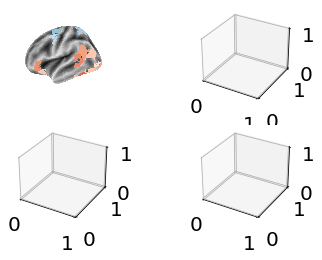

In [81]:
# surface plots
vmin,vmax = -.72,.72
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL OTHER MOVIES'

for comp in range(2):
    
    nodes = np.zeros((268,))
    if comp == 0:    
        #txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        #nodes[nodes_all_SUNS_UNSNS_unc] = coef_soc_uns[nodes_all_SUNS_UNSNS_unc] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)
        nodes[nodes_all_SUNS_UNSNS_ALL] = coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    else:
        #txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        nodes[nodes_all_SUNS_UNSNS_ALL] = coef_uns_nonsoc_ALL[nodes_all_SUNS_UNSNS_ALL]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
    surf_plot1(fig,ax,nodes,params)
    plt.savefig(os.path.join(fig_save_loc,f'ALL/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
        
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc_nosig),linewidths=1, colors=['k'],linestyles ='-',filled=False)
    plt.savefig(os.path.join(fig_save_loc,f'ALL/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

## (3) ALL OTHER MOVIES

In [300]:
title_txt = 'ALL OTHER MOVIES'
print('All movies: S v Unsure:',min(coef_soc_uns),max(coef_soc_uns))
print('All movies: Unsure v BS:',min(coef_uns_nonsoc),max(coef_uns_nonsoc))


All movies: S v Unsure: -0.31242009050342556 0.7199556339499221
All movies: Unsure v BS: -0.266758698360369 0.40560446426296987


## Correlation plots

In [83]:
# correlation plots

def plot_fig(X,Y,xlabel,ylabel,xymin,xymax):
    plt.plot(X,Y,ls='None',marker='.',alpha = .5,color='grey',label = 'mean diff. per node',markersize=8)
    r,p = stats.pearsonr(X,Y)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
   
    plt.xlim(xymin,xymax)
    plt.ylim(xymin,xymax)

    xpos = xymin+ .05*(xymax-xymin)
    ypos = xymin+ .8*(xymax-xymin)
    plt.text(xpos,ypos,f'r={r:.2f},\np={p:.1e}',fontsize=20)

    m, b = np.polyfit(X,Y, 1)
    print(np.poly1d([m,b]))
    xplot = np.linspace(xymin,xymax,10)
    plt.plot(xplot, m*xplot + b,ls='dashed',color = 'k',label = 'line of best fit\n(all nodes)')
    
    plt.vlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
    plt.hlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
   

def plot_sig_nodes(X,Y,inds):
    plt.plot(X[inds],Y[inds],ls='None',marker='+',
    mfc='k', mec='k',mew = 3, linewidth = 5,label = 'sig. across both axes',ms=12)


 
0.09687 x + 0.009471


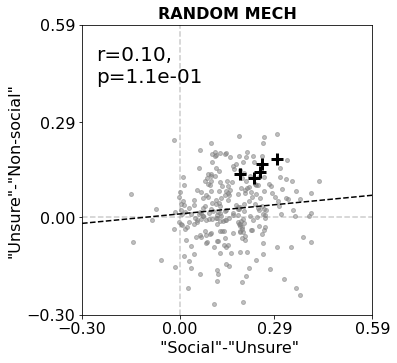

In [85]:
# CHECK THIS CELL AGAIN BEFORE RUNNING NEXT!!!!!!!

dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.59
    
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = meanDiff_sl_rand_S_UNS,meanDiff_sl_rand_UNS_NS
plot_fig(X,Y,' "Social"-"Unsure"', '"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_rand_SUNS_UNSNS_unc],Y[nodes_rand_SUNS_UNSNS_unc],mec='k',marker='o',mfc='none',ls='None')
#plt.title('RANDOM MECH')
#plt.legend(bbox_to_anchor = (1,1),fontsize =16)
plt.title('RANDOM MECH',fontweight='bold')

plt.xticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])

plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,'RAND/rand_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


## All movies, plot scatterplot and brainmaps : S > Unsure > NS

 
0.1279 x + 0.05142


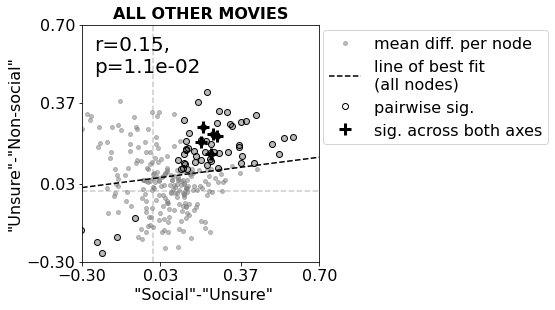

In [86]:
# scatterplot
dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.7
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = coef_soc_uns,coef_uns_nonsoc
plot_fig(X,Y,' "Social"-"Unsure"','"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',markersize=6,ls='None',label = 'pairwise sig.')
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',ls='None')
plt.title('ALL OTHER MOVIES',fontweight='bold')
plt.legend(bbox_to_anchor = (2,1.01),fontsize =16)
plt.xlim(xymin,xymax)
plt.ylim(xymin,xymax)
plt.xticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.savefig(os.path.join(fig_save_loc,'ALL_OTHERS/all_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')




# extra


In [ ]:
# check only if needed, this takes time!
# soc vs. nonsocial- - other 9 movies. 
if load_allexcept == 1:
     [coef_soc_nonsoc,pval_soc_nonsoc] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_othermovies.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    other_movies = [0,1,2,3,5,6,7,8,9] # do the analyses on all movies except rand mech

    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in other_movies:
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 9] # yes v no
        
        df['response'] = df['response'].map({0.0: "Non-social", 1.0:  "Social"})
        model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)
        if n == 0:
            print(model.fit(factors={"response":["Non-social","Social"]}))
    
        #model.fit(summary = False, verbose = False)
        coef_soc_nonsoc[n] = model.coefs['Estimate'][1]
        pval_soc_nonsoc[n]= model.coefs['P-val'][1]

    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_othermovies.npy'),[coef_soc_nonsoc,pval_soc_nonsoc])
    print('Done on/at:',datetime.now()) # cell run at)

In [116]:
fig_save_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/unsure_analyses/'

In [118]:
print(min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure))
print(min(coef_unsure_sure),max(coef_unsure_sure))

-0.2556920696778834 0.20894016749339722
-0.34809065043255083 0.29865647724689826


In [ ]:
# get a variable storing whether nodes show a difference in the end

soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"
pval_end_rand,    meandiff_end_rand, ntimepts_rand    = [np.empty((268,2)) for _ in range(3)]
pval_end_rand[:], meandiff_end_rand[:], ntimepts_rand[:] = [np.nan]*3
 
end_trs = 5
for n in range(268):# np.arange(10):
    tcn1 = np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[unsure_inds,n,-end_trs:,4],axis=1)
    #tcn1 = np.ndarray.flatten(tcs_run_z[soc_inds,   n,-2:,4])# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    #tcn2 = np.ndarray.flatten(tcs_run_z[unsure_inds,n,-2:,4])
    ntimepts_rand[n,0] =  np.sum(np.sign(np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,0] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,0] = np.nanmean(tcn1) - np.nanmean(tcn2)
    
    tcn1 = np.nanmean(tcs_run_z[unsure_inds, n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[nonsoc_inds, n,-end_trs:,4],axis=1)
    #tcn1 = np.ndarray.flatten(tcs_run_z[unsure_inds, n,-2:,4])# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    #tcn2 = np.ndarray.flatten(tcs_run_z[nonsoc_inds, n,-2:,4])
    ntimepts_rand[n,1] =  np.sum(np.sign(np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[nonsoc_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,1] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,1] = np.nanmean(tcn1) - np.nanmean(tcn2)

end_diff_rand_s_uns_ns = (np.sign(meandiff_end_rand[:,0]) == np.sign(meandiff_end_rand[:,1])) & \
     (pval_end_rand[:,0] < .05) & (pval_end_rand[:,1] < .05)
np.where(end_diff_rand_s_uns_ns)[0] # nr. of nodes which show a significant end difference